In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.metrics import (mean_absolute_error, r2_score,accuracy_score, precision_score, recall_score, f1_score, confusion_matrix)


In [ ]:
#Load Data
df = pd.read_csv("movies.csv", on_bad_lines='skip')

print(df.head())
print(df.info())
print(df.describe())

   Unnamed: 0   id                     title  \
0           0  278  The Shawshank Redemption   
1           1  238             The Godfather   
2           2  240     The Godfather Part II   
3           3  424          Schindler's List   
4           4  389              12 Angry Men   

                                            overview release_date  popularity  \
0  Imprisoned in the 1940s for the double murder ...   1994-09-23     33.2290   
1  Spanning the years 1945 to 1955, a chronicle o...   1972-03-14     33.2112   
2  In the continuing saga of the Corleone crime f...   1974-12-20     15.1058   
3  The true story of how businessman Oskar Schind...   1993-12-15     16.1859   
4  The defense and the prosecution have rested an...   1957-04-10     15.8432   

   vote_average  vote_count  
0         8.700       28306  
1         8.686       21452  
2         8.570       12961  
3         8.565       16436  
4         8.500        9128  
<class 'pandas.core.frame.DataFrame'>
RangeI

In [ ]:
#Data Preprocessing
df = df.dropna(subset=['vote_average'])

numeric_features = ['popularity', 'vote_count']
df[numeric_features] = df[numeric_features].fillna(df[numeric_features].median())

In [ ]:


#Feature Extraction / Engineering
df["log_popularity"] = np.log1p(df["popularity"])
df["vote_ratio"] = df["vote_count"] / (df["vote_count"].max() + 1)

# Define the features to be used
features = ['popularity', 'vote_count', 'log_popularity', 'vote_ratio']

X = df[features]
y_reg = df['vote_average']

In [ ]:
# Classification target (success vs flop)
threshold = 7
y_clf = (y_reg > threshold).astype(int)

X_train, X_test, y_train_reg, y_test_reg, y_train_clf, y_test_clf = train_test_split(
    X, y_reg, y_clf, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Train Models
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train_reg)
y_pred_lr = lr_model.predict(X_test_scaled)

rf_model = RandomForestRegressor(n_estimators=200, random_state=42)
rf_model.fit(X_train, y_train_reg)
y_pred_rf = rf_model.predict(X_test)

xgb_model = XGBRegressor(n_estimators=200, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train_reg)
y_pred_xgb = xgb_model.predict(X_test)

bagging_model = BaggingRegressor(
    estimator=DecisionTreeRegressor(),
    n_estimators=200,
    random_state=42
)
bagging_model.fit(X_train, y_train_reg)
y_pred_bag = bagging_model.predict(X_test)

📊 Linear Regression Cross-Validation Results
Mean MAE: 0.555 | Std: 0.002
Mean R² : 0.096 | Std: 0.005

📊 Random Forest Cross-Validation Results
Mean MAE: 0.014 | Std: 0.001
Mean R² : 0.996 | Std: 0.001

📊 XGBoost Cross-Validation Results
Mean MAE: 0.477 | Std: 0.002
Mean R² : 0.321 | Std: 0.006

📊 Bagging Regressor Cross-Validation Results
Mean MAE: 0.014 | Std: 0.001
Mean R² : 0.996 | Std: 0.001

               model  mae_mean   mae_std   r2_mean    r2_std
0  Linear Regression  0.555381  0.001571  0.095921  0.004535
1      Random Forest  0.014103  0.000685  0.995697  0.001123
2            XGBoost  0.476623  0.001908  0.321216  0.005664
3  Bagging Regressor  0.014092  0.000683  0.995714  0.001081


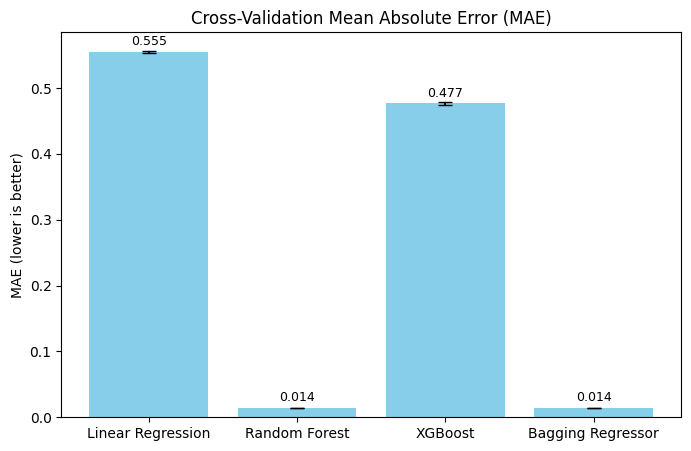

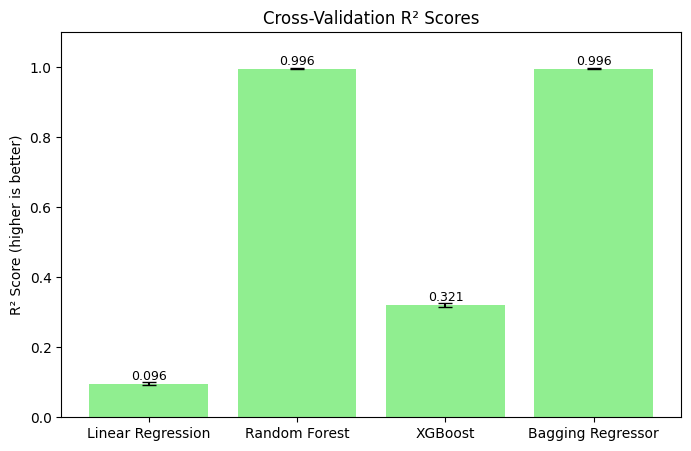

In [ ]:
# Cross Validation
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=42)

def cross_val_evaluate(model, X, y, model_name):
    mae_scores = -cross_val_score(model, X, y, cv=kf, scoring="neg_mean_absolute_error")
    r2_scores = cross_val_score(model, X, y, cv=kf, scoring="r2")

    print(f"📊 {model_name} Cross-Validation Results")
    print(f"Mean MAE: {mae_scores.mean():.3f} | Std: {mae_scores.std():.3f}")
    print(f"Mean R² : {r2_scores.mean():.3f} | Std: {r2_scores.std():.3f}\n")
    return {"model": model_name, "mae_mean": mae_scores.mean(), "mae_std": mae_scores.std(), "r2_mean": r2_scores.mean(), "r2_std": r2_scores.std()}


results = []
results.append(cross_val_evaluate(lr_model, X, y_reg, "Linear Regression"))
results.append(cross_val_evaluate(rf_model, X, y_reg, "Random Forest"))
results.append(cross_val_evaluate(xgb_model, X, y_reg, "XGBoost"))
results.append(cross_val_evaluate(bagging_model, X, y_reg, "Bagging Regressor"))

cv_df = pd.DataFrame(results)
print(cv_df)

# Plot MAE
plt.figure(figsize=(8,5))
plt.bar(cv_df["model"], cv_df["mae_mean"], yerr=cv_df["mae_std"],
        capsize=5, color="skyblue")
plt.ylabel("MAE (lower is better)")
plt.title("Cross-Validation Mean Absolute Error (MAE)")
for i, v in enumerate(cv_df["mae_mean"]):
    plt.text(i, v + 0.01, f"{v:.3f}", ha="center", fontsize=9)
plt.show()

#Plot R²
plt.figure(figsize=(8,5))
plt.bar(cv_df["model"], cv_df["r2_mean"], yerr=cv_df["r2_std"],
        capsize=5, color="lightgreen")
plt.ylabel("R² Score (higher is better)")
plt.title("Cross-Validation R² Scores")
for i, v in enumerate(cv_df["r2_mean"]):
    plt.text(i, v + 0.01, f"{v:.3f}", ha="center", fontsize=9)
plt.ylim(0, 1.1)  # keep R² between 0–1.1 for readability
plt.show()

In [ ]:
#Regression Evaluation
def evaluate_regression(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"📊 {model_name} Regression Results")
    print(f"MAE: {mae:.2f}")
    print(f"R² Score: {r2:.4f}\n")
    return mae, r2

mae_lr, r2_lr = evaluate_regression(y_test_reg, y_pred_lr, "Linear Regression")
mae_rf, r2_rf = evaluate_regression(y_test_reg, y_pred_rf, "Random Forest")
mae_xgb, r2_xgb = evaluate_regression(y_test_reg, y_pred_xgb, "XGBoost")
mae_bag, r2_bag = evaluate_regression(y_test_reg, y_pred_bag, "Bagging Regressor")

📊 Linear Regression Regression Results
MAE: 0.56
R² Score: 0.0928

📊 Random Forest Regression Results
MAE: 0.02
R² Score: 0.9955

📊 XGBoost Regression Results
MAE: 0.48
R² Score: 0.3206

📊 Bagging Regressor Regression Results
MAE: 0.01
R² Score: 0.9955



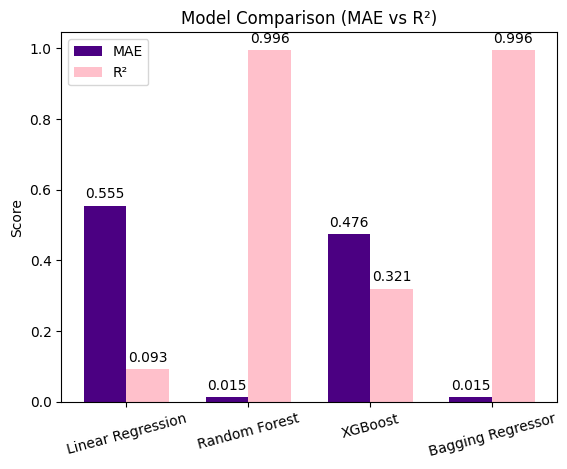

In [ ]:
# Regression comparison bar chart
models = ["Linear Regression", "Random Forest", "XGBoost", "Bagging Regressor"]
mae = [mae_lr, mae_rf, mae_xgb, mae_bag]
r2 = [r2_lr, r2_rf, r2_xgb, r2_bag]

x = np.arange(len(models))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, mae, width, label="MAE", color="indigo")
rects2 = ax.bar(x + width/2, r2, width, label="R²", color="pink")

ax.set_xticks(x)
ax.set_xticklabels(models, rotation=15)
ax.set_ylabel("Score")
ax.set_title("Model Comparison (MAE vs R²)")
ax.legend()

for rect in rects1 + rects2:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 0.02, f"{height:.3f}", ha="center")

plt.show()

In [ ]:
# Classification Evaluation
y_pred_lr_class = (y_pred_lr > threshold).astype(int)
y_pred_rf_class = (y_pred_rf > threshold).astype(int)
y_pred_xgb_class = (y_pred_xgb > threshold).astype(int)
y_pred_bag_class = (y_pred_bag > threshold).astype(int)

def evaluate_classification(y_true, y_pred_class, model_name):
    acc = accuracy_score(y_true, y_pred_class)
    prec = precision_score(y_true, y_pred_class)
    rec = recall_score(y_true, y_pred_class)
    f1 = f1_score(y_true, y_pred_class)
    cm = confusion_matrix(y_true, y_pred_class)

    print(f"📊 {model_name} Classification Results")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1-score : {f1:.4f}")
    print("Confusion Matrix:\n", cm, "\n")

    return acc, prec, rec, f1, cm

metrics_lr  = evaluate_classification(y_test_clf, y_pred_lr_class, "Linear Regression")
metrics_rf  = evaluate_classification(y_test_clf, y_pred_rf_class, "Random Forest")
metrics_xgb = evaluate_classification(y_test_clf, y_pred_xgb_class, "XGBoost")
metrics_bag = evaluate_classification(y_test_clf, y_pred_bag_class, "Bagging Regressor")

📊 Linear Regression Classification Results
Accuracy : 0.6299
Precision: 0.6311
Recall   : 0.2170
F1-score : 0.3230
Confusion Matrix:
 [[7589  723]
 [4463 1237]] 

📊 Random Forest Classification Results
Accuracy : 0.9956
Precision: 0.9949
Recall   : 0.9944
F1-score : 0.9946
Confusion Matrix:
 [[8283   29]
 [  32 5668]] 

📊 XGBoost Classification Results
Accuracy : 0.7059
Precision: 0.7919
Recall   : 0.3758
F1-score : 0.5097
Confusion Matrix:
 [[7749  563]
 [3558 2142]] 

📊 Bagging Regressor Classification Results
Accuracy : 0.9951
Precision: 0.9942
Recall   : 0.9939
F1-score : 0.9940
Confusion Matrix:
 [[8279   33]
 [  35 5665]] 



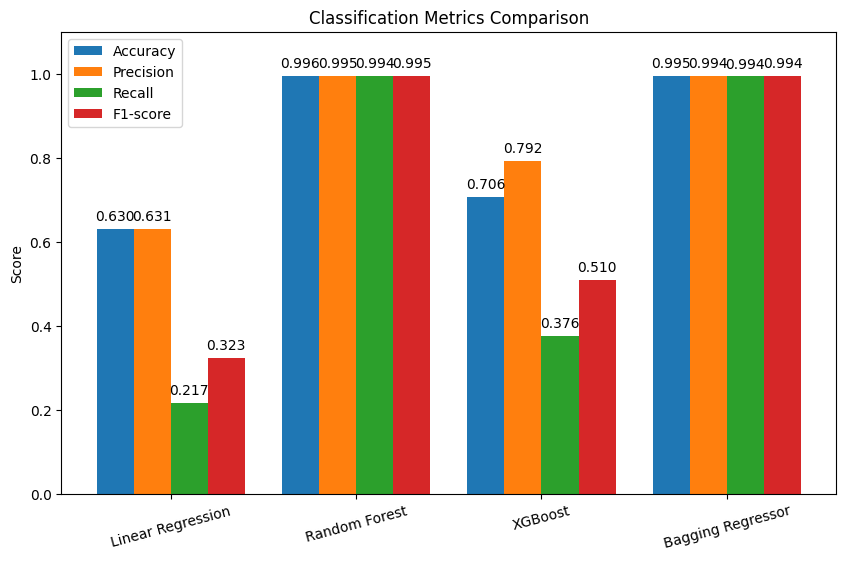

In [ ]:
# Metrics comparison chart
accs = [metrics_lr[0], metrics_rf[0], metrics_xgb[0], metrics_bag[0]]
precs = [metrics_lr[1], metrics_rf[1], metrics_xgb[1], metrics_bag[1]]
recs = [metrics_lr[2], metrics_rf[2], metrics_xgb[2], metrics_bag[2]]
f1s = [metrics_lr[3], metrics_rf[3], metrics_xgb[3], metrics_bag[3]]

x = np.arange(len(models))
width = 0.2

fig, ax = plt.subplots(figsize=(10,6))
rects1 = ax.bar(x - 1.5*width, accs, width, label="Accuracy")
rects2 = ax.bar(x - 0.5*width, precs, width, label="Precision")
rects3 = ax.bar(x + 0.5*width, recs, width, label="Recall")
rects4 = ax.bar(x + 1.5*width, f1s, width, label="F1-score")

ax.set_xticks(x)
ax.set_xticklabels(models, rotation=15)
ax.set_ylabel("Score")
ax.set_title("Classification Metrics Comparison")
ax.legend()

for rect in rects1 + rects2 + rects3 + rects4:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 0.02, f"{height:.3f}", ha="center")

plt.ylim(0,1.1)
plt.show()



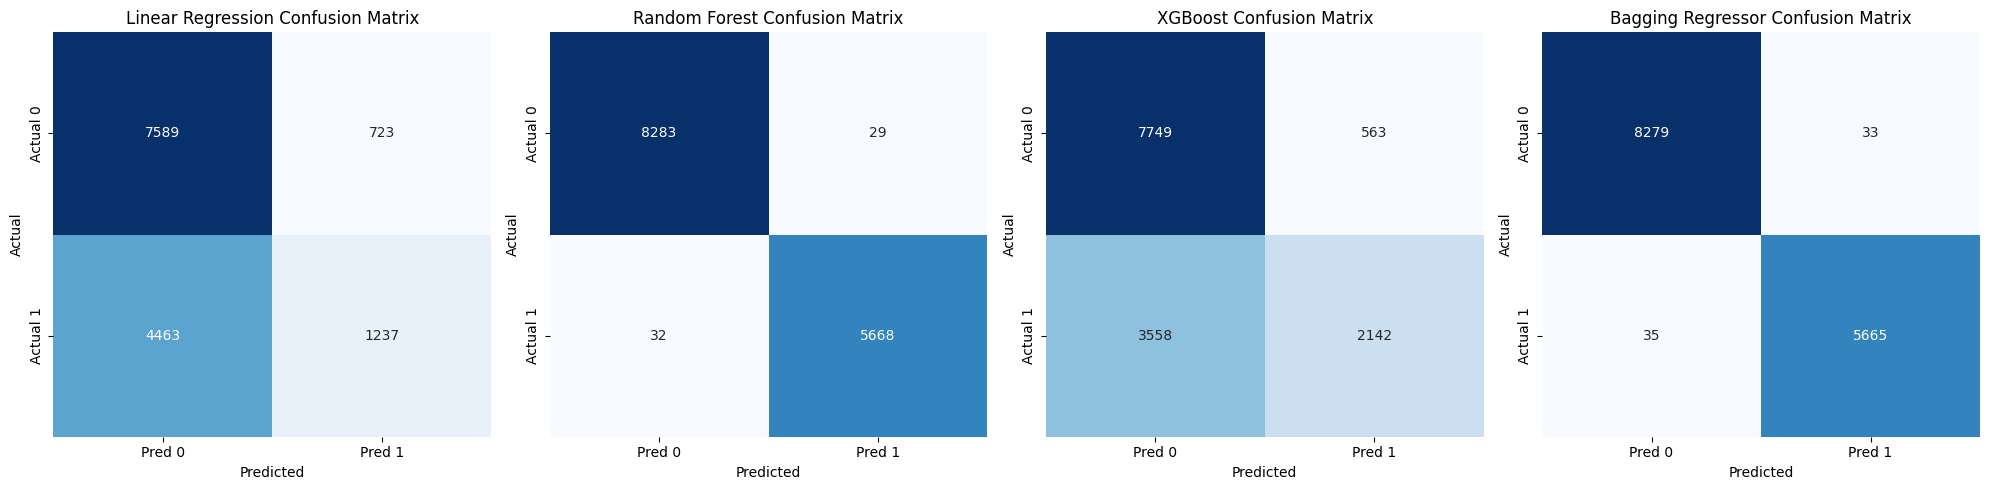

In [ ]:

# Confusion Matrices
fig, axes = plt.subplots(1, 4, figsize=(20,5))

for ax, (cm, model) in zip(axes, [(metrics_lr[4], "Linear Regression"),
                                  (metrics_rf[4], "Random Forest"),
                                  (metrics_xgb[4], "XGBoost"),
                                  (metrics_bag[4], "Bagging Regressor")]):
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax,
                xticklabels=["Pred 0", "Pred 1"],
                yticklabels=["Actual 0", "Actual 1"])
    ax.set_title(f"{model} Confusion Matrix")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

plt.tight_layout()
plt.show()


In [ ]:
# Predict New Movie
new_movie = pd.DataFrame({
    'popularity': [10.0],
    'vote_count': [1000],
    'log_popularity': [np.log1p(10.0)],
    'vote_ratio': [1000 / (df["vote_count"].max() + 1)]
})

if "main_genre" in df.columns:
    new_movie["main_genre"] = [0]  # example: set to 0 (could encode dynamically)

new_movie_scaled = scaler.transform(new_movie)
predicted_vote_average = xgb_model.predict(new_movie_scaled)
predicted_success = int(predicted_vote_average[0] > threshold)

print(f"\nPredicted Vote Average: {predicted_vote_average[0]:.2f}")
print("Predicted Success:", "Hit" if predicted_success else "Flop")


Predicted Vote Average: 6.66
Predicted Success: Flop


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://21f7bd64b65c9b88be.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


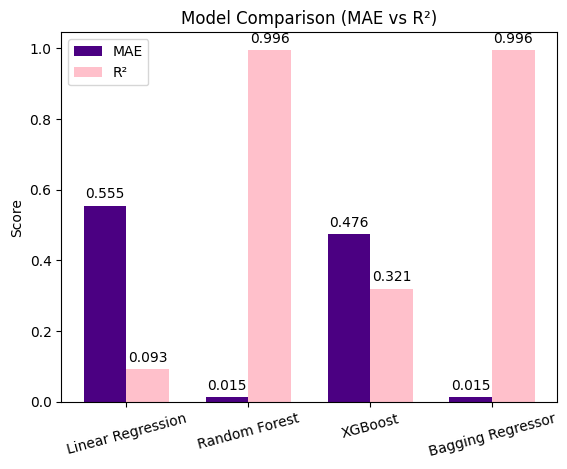

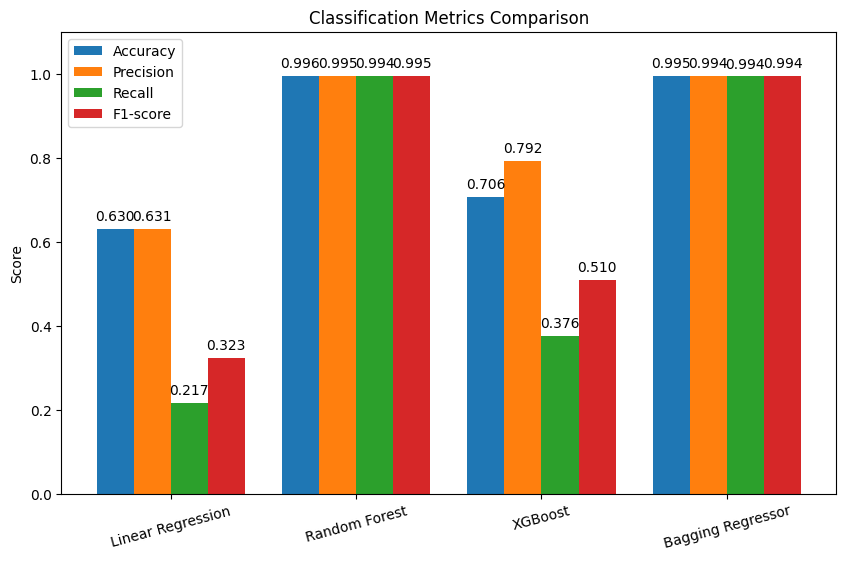

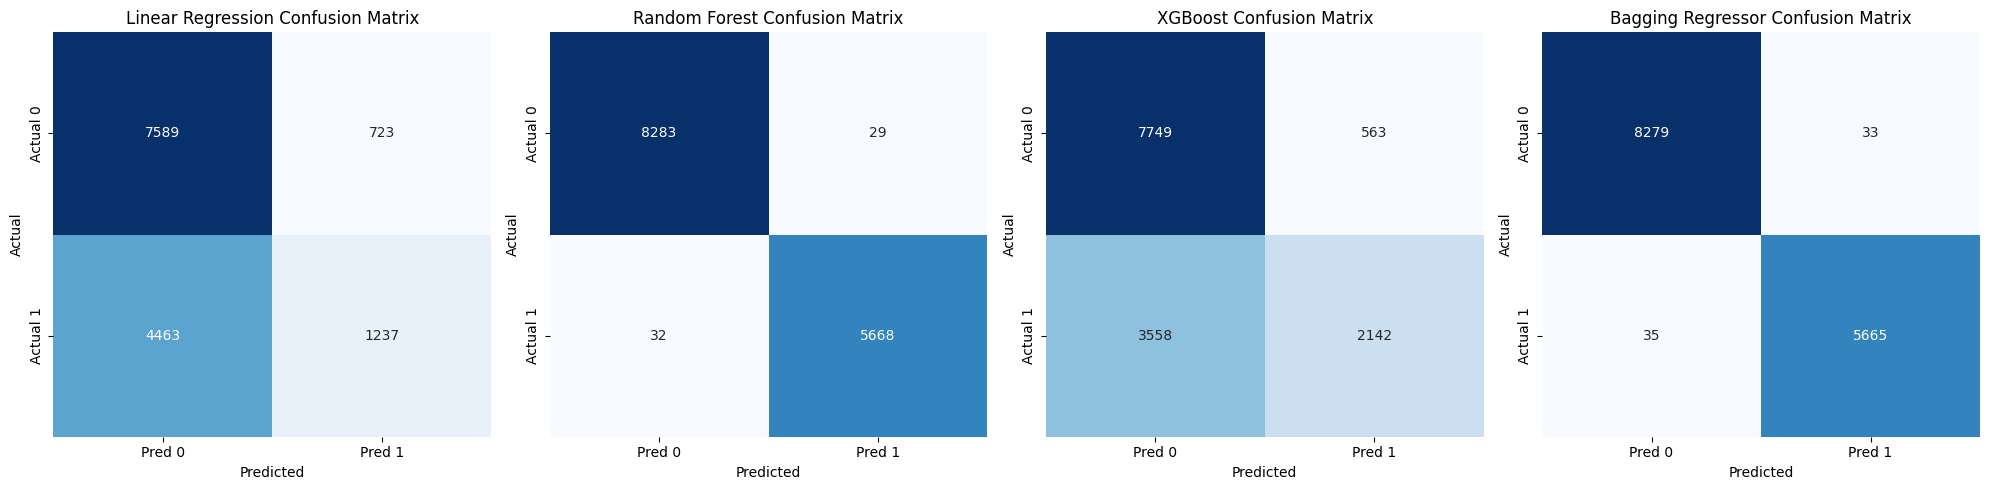

In [ ]:
import gradio as gr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Create a dictionary of models
models_dict = {
    "Linear Regression": lr_model,
    "Random Forest": rf_model,
    "XGBoost": xgb_model,
    "Bagging Regressor": bagging_model,
}

# Background images
hit_bg = "https://wallpaperaccess.com/full/3104364.jpg"   # Example HIT background
flop_bg = "https://wallpaperaccess.com/full/119960.jpg"    # Example FLOP background
default_bg = "https://wallpaperaccess.com/full/214088.jpg" # Default background

# PREDICTION FUNCTION
def predict_movie(movie_name, popularity, vote_count, model_choice):
    log_popularity = np.log1p(popularity)
    vote_ratio = vote_count / (df["vote_count"].max() + 1)

    movie_df = pd.DataFrame({
        "popularity": [popularity],
        "vote_count": [vote_count],
        "log_popularity": [log_popularity],
        "vote_ratio": [vote_ratio]
    })

    if model_choice == "Linear Regression":
        movie_scaled = scaler.transform(movie_df)
        pred = models_dict[model_choice].predict(movie_scaled)
    else:
        pred = models_dict[model_choice].predict(movie_df)


    vote_avg = pred[0]
    result = "🎬 HIT ✅" if vote_avg > threshold else "💔 FLOP ❌"
    bg_image = hit_bg if vote_avg > threshold else flop_bg

    summary = f"🎥 Movie: {movie_name}\nPredicted Vote Average: {round(vote_avg, 2)}\nResult: {result}"
    return round(vote_avg, 2), result, summary, bg_image

# Function to generate regression graphs
def regression_graphs():
    models = ["Linear Regression", "Random Forest", "XGBoost", "Bagging Regressor"]
    mae = [mae_lr, mae_rf, mae_xgb, mae_bag]
    r2 = [r2_lr, r2_rf, r2_xgb, r2_bag]

    x = np.arange(len(models))
    width = 0.35

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, mae, width, label="MAE", color="indigo")
    rects2 = ax.bar(x + width/2, r2, width, label="R²", color="pink")

    ax.set_xticks(x)
    ax.set_xticklabels(models, rotation=15)
    ax.set_ylabel("Score")
    ax.set_title("Model Comparison (MAE vs R²)")
    ax.legend()

    for rect in rects1 + rects2:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2, height + 0.02, f"{height:.3f}", ha="center")

    return fig

# Function to generate classification graphs
def classification_graphs():
    accs = [metrics_lr[0], metrics_rf[0], metrics_xgb[0], metrics_bag[0]]
    precs = [metrics_lr[1], metrics_rf[1], metrics_xgb[1], metrics_bag[1]]
    recs = [metrics_lr[2], metrics_rf[2], metrics_xgb[2], metrics_bag[2]]
    f1s = [metrics_lr[3], metrics_rf[3], metrics_xgb[3], metrics_bag[3]]

    x = np.arange(len(models_dict.keys()))
    width = 0.2

    fig, ax = plt.subplots(figsize=(10,6))
    rects1 = ax.bar(x - 1.5*width, accs, width, label="Accuracy")
    rects2 = ax.bar(x - 0.5*width, precs, width, label="Precision")
    rects3 = ax.bar(x + 0.5*width, recs, width, label="Recall")
    rects4 = ax.bar(x + 1.5*width, f1s, width, label="F1-score")

    ax.set_xticks(x)
    ax.set_xticklabels(list(models_dict.keys()), rotation=15)
    ax.set_ylabel("Score")
    ax.set_title("Classification Metrics Comparison")
    ax.legend()

    for rect in rects1 + rects2 + rects3 + rects4:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2, height + 0.02, f"{height:.3f}", ha="center")

    plt.ylim(0,1.1)
    return fig

# Function to generate confusion matrix graphs
def confusion_matrix_graphs():
    fig, axes = plt.subplots(1, 4, figsize=(20,5))

    for ax, (cm, model) in zip(axes, [(metrics_lr[4], "Linear Regression"),
                                      (metrics_rf[4], "Random Forest"),
                                      (metrics_xgb[4], "XGBoost"),
                                      (metrics_bag[4], "Bagging Regressor")]):
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax,
                    xticklabels=["Pred 0", "Pred 1"],
                    yticklabels=["Actual 0", "Actual 1"])
        ax.set_title(f"{model} Confusion Matrix")
        ax.set_xlabel("Predicted")
        ax.set_ylabel("Actual")

    plt.tight_layout()
    return fig


# BUILD GRADIO UI
with gr.Blocks(css=f".gradio-container {{background: url('{default_bg}') no-repeat center center fixed; background-size: cover;}}") as demo:
    title = gr.Markdown("<h1 style='color:white;text-align:center'>🎥 Movie Success Prediction</h1>")
    subtitle = gr.Markdown("<p style='color:white;text-align:center'>Enter movie details and check if it's a Hit or Flop!</p>")

    with gr.Tab("🎬 Prediction"):
        with gr.Row():
            with gr.Column(scale=1):
                movie_name = gr.Textbox(label="Movie Name", placeholder="Enter movie name...")
                popularity = gr.Number(label="Popularity", value=10.0)
                vote_count = gr.Number(label="Vote Count", value=1000)
                model_choice = gr.Dropdown(choices=list(models_dict.keys()), value="XGBoost", label="Select Model")
                predict_btn = gr.Button("🚀 Predict")
            with gr.Column(scale=1):
                vote_avg = gr.Textbox(label="Predicted Vote Average", interactive=False)
                success_status = gr.Textbox(label="Prediction Result", interactive=False)
                summary = gr.Textbox(label="Summary", interactive=False, lines=3)

        # Hidden HTML component to inject background dynamically
        bg_html = gr.HTML()

        def change_background(vote_avg, result, summary, bg_image):
            js = f"""
            <script>
            document.querySelector('.gradio-container').style.backgroundImage = "url('{bg_image}')";
            </script>
            """
            return vote_avg, result, summary, js

        predict_btn.click(
            fn=predict_movie,
            inputs=[movie_name, popularity, vote_count, model_choice],
            outputs=[vote_avg, success_status, summary, bg_html],
        ).then(
            fn=change_background,
            inputs=[vote_avg, success_status, summary, bg_html],
            outputs=[vote_avg, success_status, summary, bg_html],
        )

    with gr.Tab("📊 Regression Metrics"):
        gr.Plot(regression_graphs)

    with gr.Tab("📈 Classification Metrics"):
        gr.Plot(classification_graphs)

    with gr.Tab("🧩 Confusion Matrices"):
        gr.Plot(confusion_matrix_graphs)

demo.launch(share=True)